In [ ]:
#google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/wka')
!ls

Mounted at /content/drive
 2020_A46.json
 2020_A46.xml
 2020_A50.json
 2020_A50.xml
 2020_A53.json
 2020_A53.xml
 2020_A59.json
 2020_A59.xml
 2020_A90.json
 2020_A90.xml
 2020_B05.json
 2020_B05.xml
 2020_C04.json
 2020_C04.xml
 2020_F010.json
 2020_F010.xml
 2020_F021.json
 2020_F021.xml
 2020_F036.json
 2020_F036.xml
 2020_F203.json
 2020_F203.xml
 2020_F262.json
 2020_F262.xml
 2020_F300.json
 2020_F300.xml
'5_Walnut Project.json'
 annotated_images
 annotations_2020_a59.json
 area.png
 bboxes_images
 bbox_inference.py
 CNN_Walnut_1042020_2019WalnutDryerExp.csv
 CNN_Walnut_12022020_2017.csv
 CNN_Walnut_12042020_2018.csv
 CNN_Walnut_12042020_2019.csv
 CNN_Walnut_12042020_2019PlasticBagExp.csv
 CNN_Walnut_12042020_30DegreeRoomExp_2017.csv
 coco_eval.py
 coco_utils.py
 colabDetect.ipynb
 config.py
 cvat_xml_masks.ipynb
 cvat_xml_masks.py
 datatools.py
 detect.py
 engine.py
 evaluate_model.py
 generate_masks.py
 GoogleColabBasics_CNNWalnut.docx
 inference.py
 instances.png
 LICENSE
 log

In [ ]:
#Imports
# Mask R-CNN
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import argparse
import torch
import torchvision
# # sys.path.append(ROOT_DIR)  # To find local version of the library
from datatools import GrapeBunchDataset
import datatools as dtools
# import utils
# from engine import evaluate
import skimage.io
import pandas as pd
# scikit image region properties
from skimage import color
from skimage import data, util, measure
from skimage.measure import label, regionprops, regionprops_table

#for generating masks
import predicted_masks

#*********************************************************************
#from prediction_mask.py
from PIL import Image
from glob import glob
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
sys.path.append(os.path.join(sys.path[0]))  # To find local version of the library
# from datatools import GrapeBunchDataset
# import datatools as dtools
import utils
from engine import evaluate
from torchvision.models.detection.rpn import AnchorGenerator
import torch
import warnings

In [ ]:
#prediction deffinitions and settings
print('prediction deffinitions and settings')
warnings.filterwarnings('ignore')
CLASS_NAMES = ['__background__', 'Walnut']
device = torch.device('cuda')
num_classes=2
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, rpn_nms_thresh=0.15, box_nms_thresh=0.05) # deafult nms thresholds = 0.5, 0.7
in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
    # and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
# model.load_state_dict(torch.load('final_model_sky_2.pth'), strict=False)   # the name of your saved model, should be 'best_model.pth' by default
# model.eval()
state_dict = torch.load( "new_final_model.pth")
model.load_state_dict(state_dict)
model.to('cuda')
model.eval()
# # Aply mask
#     for c in range(3):
#         image[:, :, c] = np.where(mask > 0.5,image[:, :, c] * (1 - alpha) + alpha * color[c] * 255, image[:, :, c])
#     return image

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>confidence).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]


    return masks , pred_boxes, pred_class, pred_score

#*********************************************************************

# Create final data tabel calsses dictionay
final_df = pd.DataFrame()
attribute_dic = {'class_ids':[], 'area':[]} #*#

print('end predictions and settings')

prediction deffinitions and settings


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

end predictions and settings


In [ ]:

#***************************loop for processing imgs in walnut_images directory ***************************
# iteartivly process the images. 0 to ~ 100 walnuts per image
print('iteartivly process the images. 0 to ~ 100 walnuts per image')

wlnt_path = 'walnut_images/'
wlnt_dir = os.listdir('walnut_images')
for i, wlnt_img in enumerate(wlnt_dir):
    #print('image' ,i)

    #Iniate color space higherarchical data frame
    iterables = [['lab','rgb'], ['x','y','z'], ['10','25','50','75','90']]
    tab_idx = pd.MultiIndex.from_product(iterables, names=['color_space','channel','percentile'])
    walnut_colors_df = pd.DataFrame(columns=tab_idx)
    color_spaces = ['lab','rgb']
    channels = ['x','y','z']
    percentiles = ['10','25','50','75','90']

    img_path = wlnt_path + wlnt_img
    original_image = plt.imread(img_path)
    #tensor_image = torch.from_numpy(np_image)

#*********************************************************************

    # results of inference on one image as boolian masks
    masks, boxes, pred_class, score = get_prediction(img_path, confidence = 0.5)

#*********************************************************************


#***************************Finds mask's and masked image's attributes******************************************

    #Finds each mask's centroids and area
    mask_centroid_x = [None] * (masks.shape[0])
    mask_centroid_y = [None] * (masks.shape[0])

    mask_area =  area_cv2 = perimeter_cv2 = [None] * (masks.shape[0])


    for k in range(masks.shape[0]):
        mask_bool = (masks[k,:,:]).astype(np.float32)
        Moments = cv2.moments(mask_bool)
        mask_centroid_x[k] = int((Moments["m10"]/Moments["m00"]))  #rounded to nearest whole pixel value.
        mask_centroid_y[k] = int((Moments["m01"]/Moments["m00"]))


        mask_area[k] = np.sum(masks[k,:,:])
        #area_cv2[k] = cv2.contourArea(mask_bool)
        #perimeter_cv2[k] = cv2.arcLength(mask_bool*1,True)
        #mean_val_cv2 = cv.mean(rgb_img,mask = mask_bool)


    temp1 = np.array(original_image)
    #temp1 = skimage.io.imread('walnut_images/' + wlnt_img)

    #sum of all walnut masks in one image
    sum_masks = np.sum(masks,axis=0)
    sum_masks_3d = np.expand_dims(sum_masks,2)
    temp_masked = sum_masks_3d*temp1

    # Image color space conversion
    grayscale = color.rgb2gray(temp_masked)
    lab_img = cv2.cvtColor(temp1, cv2.COLOR_BGR2LAB)
    #lab_img = color.rgb2lab(temp1)
    #lab_img = color.rgb2lab(temp_masked)
    #hsv_img = color.rgb2hsv(sum_masks)

    #Scikit image anlysis
    # label_img = label(sum_masks)
    # regions = regionprops(label_img)
    # props = regionprops_table(label_img, intensity_image=grayscale, properties=('label', 'bbox','centroid', 'area', 'orientation',
    #         'major_axis_length', 'minor_axis_length','perimeter',  'max_intensity','min_intensity',
    #         'mean_intensity','equivalent_diameter','filled_area'))

    # Skiimg region properties data frame
    # scikit_data_table = pd.DataFrame(props)
    #scikit_data_table = scikit_data_table[scikit_data_table["area"] >1600]

    rgb_temp = temp1.copy()
    lab_temp = lab_img
    # Finds Percentiles
    #for k, mask_label in enumerate(np.unique(label_img)[1:]):
    for k in range(masks.shape[0]):
    #for k, mask_label in enumerate(np.array(scikit_data_table['label'])):
        #idx = label_img == mask_label
        idx = masks[k,:,:]
        rgb_temp = temp1.copy()*np.dstack([idx,idx,idx])
        lab_temp = lab_img.copy()*np.dstack([idx,idx,idx])

        # Gausian distribution/percentile of walnut colors
        # Removes 0's from masked image and and retuns a 1 pixel wide image wth all the non zero values
        # 1D Rgb remove empty Pixels
        rgb_remove = rgb_temp[rgb_temp[:,:, 0] != 0]
        rgb_remove = rgb_remove[rgb_remove[:, 1] != 0]
        rgb_remove = rgb_remove[rgb_remove[:, 2] != 0]
        rgb_remove = np.expand_dims(rgb_remove,1)

        # 1D Lab Rgb remove empty Pixels
        lab_remove = lab_temp[lab_temp[:,:,0] != 0]
        lab_remove = lab_remove[lab_remove[:, 1] != 0]
        lab_remove = lab_remove[lab_remove[:, 2] != 0]
        lab_remove = np.expand_dims(lab_remove,1)

        # Populates colors data table ~3000 calculations of np.percentile()
        for ii in color_spaces:
            if ii == 'lab':
                for nn,jj in enumerate(channels):
                    for rr,kk in enumerate(percentiles):
                        walnut_colors_df.loc[k,(ii,jj,kk)] = np.percentile(lab_remove[:,:,nn], q = int(percentiles[rr]))
            elif ii == 'rgb':
                for nn,jj in enumerate(channels):
                    for rr,kk in enumerate(percentiles):
                        walnut_colors_df.loc[k,(ii,jj,kk)] = np.percentile(rgb_remove[:,:,nn], q = int(percentiles[rr]))

    #add labels
    # color_label = np.array(scikit_data_table['label'])
    color_label = np.array(range(masks.shape[0]))
    walnut_colors_df.insert(0,'label', color_label)

    # print("masking:", end-start)
    # print("color loop:", end_ii-start_ii)
    # print("percentiles:", end_k- start_k)
    # print("sci&color", end_i - start_i)


    #********* class types and ids fidning areas for merge
    # attribute_dic['class_ids'] = pred_class
    # #attribute_dic['class_ids'] = results[0]['class_ids']
    # attribute_dic['area'] = mask_area
    # class_df = pd.DataFrame(attribute_dic)

    #adjust walnut_color_df labels
    walnut_colors_df.columns = walnut_colors_df.columns.map('_'.join).str.strip('_')

    #Inserts additonal atrributes to datatable
    walnut_colors_df.insert(1,'class_ids',pred_class)
    walnut_colors_df.insert(2,'centroid_x', mask_centroid_x)
    walnut_colors_df.insert(3,'centroid_y', mask_centroid_y)
    walnut_colors_df.insert(4,'area', mask_area)
    #walnut_colors_df.insert(5,'perimeter_cv2', perimeter_cv2)
    #walnut_colors_df.insert(6,'area_cv2',area_cv2)

    temp_datatable = walnut_colors_df

    # append lists of scikit and colors dfs an image id
    # walnut_colors_list.append(walnut_colors_df)
    # scikit_list.append(scikit_data_table)
    # Image_id_list.append(image_id)

    # Combined data table
    # temp_datatable = walnut_colors_df.merge(scikit_data_table)
    #temp_datatable = temp_datatable.merge(class_df)

    #temp_datatable = pd.concat([scikit_data_table, walnut_colors_df], axis=1)

    # attribute_ids = results[0]['class_ids']
    # temp_datatable.insert(0, 'class_ids', class_ids)

    image_id = str(wlnt_dir[i][:-4])
    temp_datatable.insert(0, 'image_id', image_id)

    #remove Nans

   # print("10:", time.clock() )
    final_df = pd.concat([final_df, temp_datatable], axis=0)

    #final_df.append(temp_datatable)

#Concatinate df outside of loop
#concatinate all scikit_data_tables to repective walnutcolors_df, and image id's

# plt.imshow(mask_bool)
# plt.scatter(mask_centroid_x[k],mask_centroid_y[k])


iteartivly process the images. 0 to ~ 100 walnuts per image


In [ ]:
#convert to long format and csv
final_walnut_df = pd.melt(final_df, id_vars=['image_id', 'label'])

csv_path =  'wlnt_detection_results/'

name = 'magick_2022'
print('convert to long format and csv' )

if name:
    final_walnut_df.to_csv(csv_path + name + '.csv')
else:
    final_walnut_df.to_csv(csv_path + time.asctime() +'.csv')


# # %%
# #last image masked. Maskrcnn
# test_image = original_image.copy()
# for c in range(3):
#     test_image[:, :, c] = np.where(sum_masks < 0.5, test_image[:, :, c] * 0, test_image[:, :, c])
#plt.imshow(test_image)
#
# #last image scikit labels. Maskrcnn + scikit image
# image_label_overlay = color.label2rgb(label_img, image=original_image, bg_label=0)

# #instace segmentation from MaskRCNN
# test_image = original_image.copy()
# mask_label = 0
# for c in range(3):
#     test_image[:, :, c] = np.where(masks[mask_label,:,:] < 0.5, test_image[:, :, c] * 0, test_image[:, :, c])

# #instace from scikit labels
#test_image = original_image.copy()
# scikit_label = 1
# for c in range(3):
#     test_img[:, :, c] = np.where(label_img != scikit_label, test_img[:, :, c]*0, test_img[:, :, c])
#plt.imshow(test_img)
# %%

convert to long format and csv


TypeError: ignored

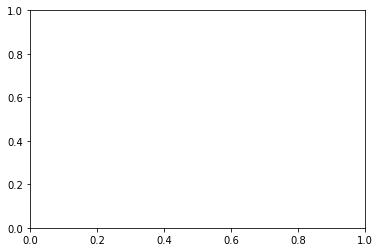

In [ ]:
#Visualize and animate
%matplotlib inline
from matplotlib import animation, rc

rc('animation', html='html5')
fig, ax = plt.subplots()

ax.set_xlim( 0, mask_bool.shape(0))
ax.set_ylim(0, mask_bool.shape(1))

#masked_idx, = ax.imshow()
masked_idx, = ax.plot([], [])
cent_idx, = ax.scatter([], [])

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
anim

#image * mask + scatter of coordinates

#